<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exercise 10: Spatial Networks</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Instructors: Anastassia Vybornova & Ane Rahbek Vierø</h3>
</div>

In today's exercise we will be working with spatial network analysis using OSMnx, Pandana and Spaghetti.

This notebook was developed with inspiration from:

* OSMnx examples: https://github.com/gboeing/osmnx-examples/blob/main/notebooks/06-stats-indicators-centrality.ipynb
* Course in Urban Data Science: https://github.com/gboeing/ppd599/blob/main/modules/08-urban-networks-ii/lecture.ipynb


## Working with Pandana - useful links

- [Pandana installation etc.](https://udst.github.io/pandana/index.html)
- [Pandana tutorials](https://github.com/UDST/pandana/blob/main/examples/Pandana-demo.ipynb)

## Short Instructions 

1. **Download** 3 different street networks (based on custom filtering) from OSMnx for Frederiksberg Municipality *(or choose somewhere else - but it can take a little while to calculate network metrics for larger networks)*.

2. **Compute** basic stats. Do you think the results matches your experience of the area?

3. **Compute** a network metric of your own choice for all three network types (e.g. betweenness, closeness, directness etc.) and **visualise** them.

4. **Compute & visualise** pedestrian accessibility to a POI of your own choice using a combination of OSMnx and pandana.


### Data

All data used today are downloaded from OSM, so thank you to all OSM contributors!

## Coding starts here :)

In [1]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import numpy as np
import networkx as nx
import pandas as pd
import pandana
import seaborn as sns

from haversine import haversine, haversine_vector

import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d

import matplotlib
import spaghetti
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
ox.__version__

/opt/conda/lib/python3.9/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


'1.1.1'

### Download data with OSMnx

First step is to download the data from OSM using OSMnx.
OSMnx has support for [applying custom filters](https://github.com/gboeing/osmnx-examples/blob/main/notebooks/08-custom-filters-infrastructure.ipynb), which allows you to create a network with a subset of all available edges, depending on some criteria.

The custom filtering is quering the [OSM Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API), which can be a bit complicated, so we have provided 3 examples here, based on [Michaels research](https://github.com/mszell/bikenwgrowth/blob/master/parameters/parameters.py). One issue with the custom filtering is that it is not that well suited for having multiple conditions at the same time. One way of solving it is the way we will do it here (getting one graph per condition and combining them at the end). 

Another option is to convert the full network to a GeoDataFrame with edges, retrieve the relevant edges, and rebuild the graph from those. We will get more in to this when discussing the details of OSMnx in a couple of weeks :)

The networks provided here are:
- **car50:** One for car traffic, but only including streets with a max speed of 50 km/h or below
- **pedestrian:** One with all edges where pedestrians are allowed
- **bike:** One with designated cycling infrastructure and streets with a max speed of 30 km/h



In [2]:
# Get 3 networks from OSMnx using 3 different custom filters 
# and 3 different levels of complexity for getting a custom network

# If we set **retain all = False**, this means we only keep 
# the largest connected component when getting the network!

place = 'Frederiksberg Municipality'

#### pedestrian
G_pedestrian =  ox.graph_from_place(place, network_type='walk', retain_all=True)

#### car50
cf_car = '["maxspeed"~"^50$|^30$|^20$|^15$|^10$|^5$|^20 mph|^15 mph|^10 mph|^5 mph"]'
G_car50 = ox.graph_from_place(place, network_type='drive', retain_all=True, custom_filter=cf_car)

#### bike

# custom filter for all cycling infrastructure
cf_bike = {'bike_cyclewaytrack': '["cycleway"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_highwaycycleway': '["highway"~"cycleway"]',
            'bike_cyclewayrighttrack': '["cycleway:right"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_cyclewaylefttrack': '["cycleway:left"~"track|lane|opposite_lane|opposite_track|shared_lane|designated"]',
            'bike_cyclestreet': '["cyclestreet"]',
            'bike_bicycleroad': '["bicycle_road"]',
            'bike_livingstreet': '["highway"~"living_street"]'
            } 

bike_graphs = []

for graph_type, cf in cf_bike.items():
    try:
        G_bike =  ox.graph_from_place(place, network_type='all', retain_all=True, custom_filter=cf)
        bike_graphs.append(G_bike)
    except ValueError:
        print(f'No data returned for {graph_type}!')
        continue

G_bike = nx.compose_all(bike_graphs)

# To get the largest connected component of the composed bike network, use NetworkX connected components function
#largest_connected_component = max(nx.connected_components(ox.get_undirected(G_bike_all)), key=len)
#G_bike = G_bike_all.subgraph(largest_connected_component)

No data returned for bike_cyclestreet!
No data returned for bike_bicycleroad!


In [3]:
# Project
G_car50 = ox.project_graph(G_car50,to_crs='EPSG:25832')
G_bike = ox.project_graph(G_bike,to_crs='EPSG:25832')
G_pedestrian = ox.project_graph(G_pedestrian,to_crs='EPSG:25832')

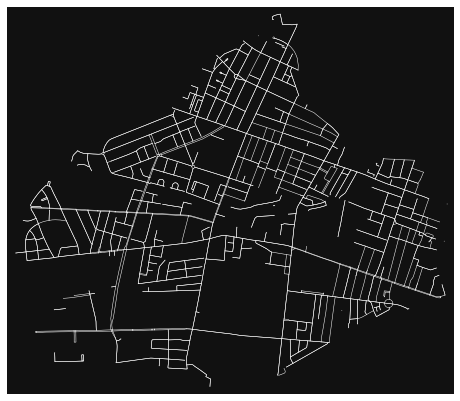

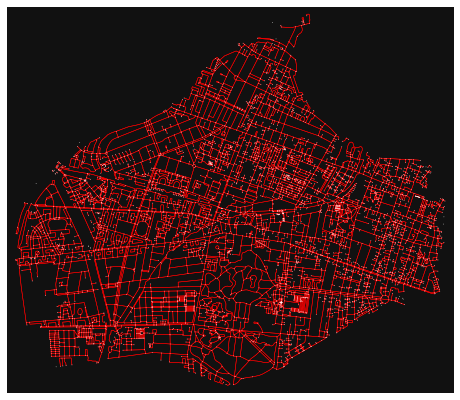

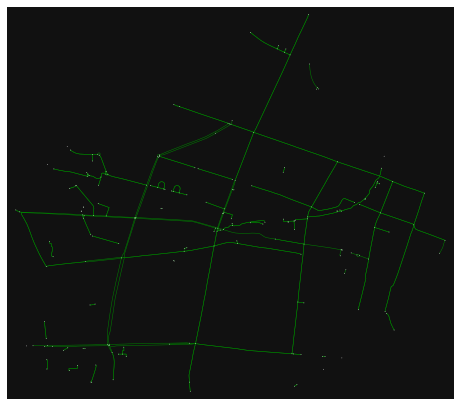

In [4]:
# Plot
ox.plot_graph(G_car50, node_size=0.5, edge_color="w", edge_linewidth=0.5)
ox.plot_graph(G_pedestrian, node_size=0.5, edge_color="red", edge_linewidth=0.5)
ox.plot_graph(G_bike, node_size=0.5, edge_color="green", edge_linewidth=0.5);

### Compute basic stats and network centrality metric

In [5]:
# Compute basic stats

# First we need the area of the place
# Get the street network for a place, and its area in square meters

In [6]:
# Compute closeness centrality for all three networks

Have a close look at the bike closeness centrality! This is what happens when the graph consist of many unconnected components - the distance between them is infinite.

In [7]:
# Plot graphs (it can take a little while)

Network centrality metrics are not only useful for analysis: As you can see here, plotting them can also indicate if we have problems with the network topology, such as unconnected components.

## Urban Accessibility

For this task you will be calculating pedestrian accessibility/walking distance to a POI of your own choice, using **pandana**.


We have started out with creating the initial OSMnx network for you (to make things a bit easier we are working with an unprojected graph in the beginning).
From here, the workflow is as follows:

1. Define a max walking time in minutes and in seconds

2. Define the assumed average walking speed (km per hour)

3. Set the average walking speed on every edge in your graph, to an attribute name 'speed_kbp'

4. Use the OSMnx function add_edge_travel_times to compute how long it will take to travel down each edge

5. Get all the POIs of whatever type you are interested in, within your study area. You can use the bounding box of the graph nodes to define the study area.

6. Reproject the POIs to a projected CRS and get their geometries as centroids

7. Reproject graph to a projected CRS

8. Convert the graph to a node and edge dataframe containing respectively the x and y columns(coordinates) and the u, v and travel time columns

9. Use these geodataframes to create the pandana network

10. Use the pandana network.set_pois() and network.nearest_pois() to get the distance to the nearest POIs from each node

11. Plot the result (one way of plotting the nodes visualised with their walk distance to the nearest POI is to simply plot them as a scatter plot with the walking distance as the color value)


Hint: You can add a new attribute to your edge data by iterating over the edges like this:

####### EXAMPLE #######

*for u, v, data in G.edges(data=True):
    data['new_attribute'] = new_value*


Hint: You create a pandana network with information about travel time like this:

####### EXAMPLE #######

*network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['travel_time']])*

### Start coding! :)

In [8]:
G_walk = ox.graph_from_place(place, network_type='walk', retain_all=False)

In [9]:
# specify parameters for the analysis

In [10]:
# set a uniform walking speed on every edge

In [11]:
# Get all the "fresh food" stores on OSM within the study site
# tags = {'shop': ['grocery', 'greengrocer', 'supermarket']}

In [12]:
# construct the pandana network
# For this we first need the nodes and edges as geodataframes

In [13]:
# Some amenities might be polygons, but we need them as points, 
# so let's extract the centroids from the amenities' geometries
# set the amenities' locations on the network 

In [14]:
# calculate travel time to nearest 3 amenities from each node in network

In [15]:
# Plot distance to nearest amenity from each node